### Двумерное уравнение теплопроводности

In [2]:
from math import cos, sin, pi, exp
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm import tqdm
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, plot, iplot

%pylab inline
%matplotlib inline

sns.set_style("whitegrid")
pylab.rcParams["figure.figsize"] = [12, 5]
init_notebook_mode(connected=True)

Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning:

pylab import has clobbered these variables: ['exp', 'sin', 'plot', 'cos', 'pi']
`%matplotlib` prevents importing * from pylab and numpy



## Формулировка задания и граничные условия

<img src='task_def.jpg'/>

Зададим начальные условия

In [10]:
Nx, Ny = 100, 100
delta_t = 1e-2
t_max = 10
Alpha = np.array([1, 2, 5, 100])
lambda_x = 1e-4

Определим функцию $\phi(x, y, t)$

In [11]:
def fi_range(x_range, y, t, lambda_y):
    return np.cos(x_range * pi) * sin(pi * y) * exp(-(lambda_x + lambda_y) * t * (pi**2))

In [12]:
def fi(x, y, t, lambda_y):
    return cos(x * pi) * sin(pi * y) * exp(-(lambda_x + lambda_y) * t * (pi**2))

Зададим значения $ x \in [ 0; 1]$ и $ y \in [ 0; 1]$

In [13]:
x_range, y_range = np.linspace(0, 1, Nx), np.linspace(0, 1, Ny)

Зададим значения шага по времени

In [14]:
h_step, tau_step = 1 / Nx, 1e-2
gamma = 1 / tau_step 

## Метод Якоби

<img src='method.jpg'/>

Инициализация $ a, b, c, f, g, \gamma $

In [15]:
def parametrs_initialisation(lambda_y):
    c, b = lambda_x / (h_step ** 2), lambda_x / (h_step ** 2)
    g, f = lambda_y / (h_step ** 2), lambda_y / (h_step ** 2)
    a = -(c + b + g + f + gamma)
    return a, b, c, f, g

Инициализация $\phi, d$

In [16]:
def first_matrix_initialisation(lambda_y):
    fi_matrix = np.matrix([fi_range(x_range, y, 0, lambda_y) for y in y_range])
    d_matrix = - gamma * fi_matrix
    return fi_matrix, d_matrix

Реализация алгоритма метода Якоби

In [17]:
def alg_step(fi_matrix, d_matrix, a, b, c, f, g, lambda_y):
    max_delta = - np.infty
    fi_matrix_prev = fi_matrix
    for i in range(1, Nx - 1):
        for j in range(1, Ny - 1):
            fi_matrix[i, j] = 1 / a * (d_matrix[i, j] - c * fi_matrix_prev[i - 1, j] - b * fi_matrix_prev[i + 1, j] - g * fi_matrix_prev[i, j - 1] - f * fi_matrix_prev[i, j + 1])
            if (max_delta < abs(fi_matrix_prev[i, j] - fi(x_range[i], y_range[j], t, lambda_y))):
                max_delta = abs(fi_matrix_prev[i, j] - fi(x_range[i], y_range[j], t, lambda_y))
    return max_delta, fi_matrix

## Main Loop

Отрисовывает график распределения температуры

In [18]:
def print_heat_distr(fi_matrix, alpha):
    data = [go.Surface(z=fi_matrix)]
    layout = go.Layout(title='Alpha ' + str(alpha), autosize=False, width=500, height=500, 
                       margin=dict(l=65, r=50, b=65, t=90))
    fig = go.Figure(data=data, layout=layout)
    iplot(fig, filename='yakobi-equation') 

In [25]:
# для каждого alpha будем сохранять значения ошибок в зависимости от итерации
delta = {alpha:[] for alpha in Alpha}

for alpha_ind in tqdm(range(len(Alpha))):
    t = 1e-2
    lambda_y = Alpha[alpha_ind] * lambda_x  
    
    # инициализируем начальные значения
    a, b, c, f, g = parametrs_initialisation(lambda_y)
    fi_matrix, d_matrix = first_matrix_initialisation(lambda_y)
    
    # обновляем матрицу fi
    while (t <= t_max):
        
        # получаем значение максимального отклонения для итерации, делаем шаг алгоритма
        max_delta, fi_matrix = alg_step(fi_matrix, d_matrix, a, b, c, f, g, lambda_y)
        
        delta[Alpha[alpha_ind]].append(abs(max_delta))
        d_matrix = - gamma * fi_matrix 
        t += tau_step 
    
    # отрисовываем график распределения температуры
    print_heat_distr(fi_matrix, Alpha[alpha_ind])

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

 25%|████████████████████▊                                                              | 1/4 [02:49<08:28, 169.34s/it]

 50%|█████████████████████████████████████████▌                                         | 2/4 [05:30<05:33, 166.83s/it]

 75%|██████████████████████████████████████████████████████████████▎                    | 3/4 [08:37<02:53, 173.04s/it]

100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [11:29<00:00, 172.60s/it]


## Требования
<img src='req.jpg'/>

Для каждого $\alpha$ нарисуем график значения ошибки от итерации $\Delta(i)$

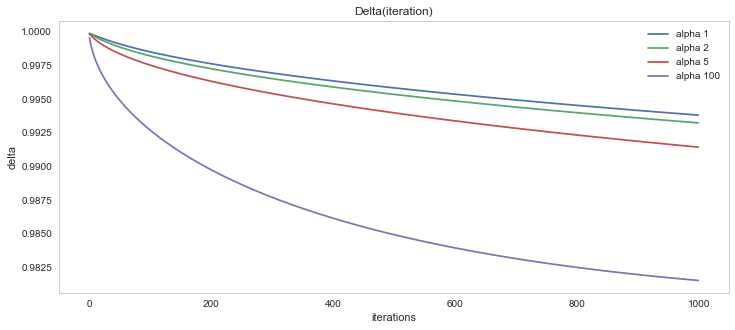

In [27]:
plt.title('Delta(iteration)')
for alpha, delta_alpha in delta.items():
    plt.plot(range(len(delta_alpha)), delta_alpha, label="alpha "+str(alpha))

plt.xlabel('iterations')
plt.ylabel('delta')
plt.legend()
plt.grid()
plt.figure(figsize=(10, 10))
plt.show()


Видно, что чем больше $alpha$, тем хуже сходится метод Якоби

Посмотрим, как зависит значение ошибки от итерации, если увеличивать количество узлов решётки. Возьмём значение $\alpha = 1$, а значения $Nx = Ny \in [1000, 10000]$

In [19]:
NX = [10, 50, 100]
alpha = 1
lambda_y = alpha * lambda_x  

Перепишем функцию инициализации параметров, для того чтобы она также учитывала шаг по сетке

In [20]:
def parametrs_initialisation_with_step(lambda_y, h_step):
    c, b = lambda_x / (h_step ** 2), lambda_x / (h_step ** 2)
    g, f = lambda_y / (h_step ** 2), lambda_y / (h_step ** 2)
    a = -(c + b + g + f + gamma)
    return a, b, c, f, g

Перепишем функцию инициализации матриц, для того чтобы она также учитывала диапазон значений

In [21]:
def first_matrix_initialisation_with_range(lambda_y, x_range, y_range):
    fi_matrix = np.matrix([fi_range(x_range, y, 0, lambda_y) for y in y_range])
    d_matrix = - gamma * fi_matrix
    return fi_matrix, d_matrix

Перепишем функцию для шага алгоритма, для того чтобы она также учитывала шаг $Nx$

In [22]:
def alg_step_with_step(fi_matrix, d_matrix, a, b, c, f, g, lambda_y, Nx):
    max_delta = - np.infty
    fi_matrix_prev = fi_matrix
    for i in range(1, Nx - 1):
        for j in range(1, Nx - 1):
            fi_matrix[i, j] = 1 / a * (d_matrix[i, j] - c * fi_matrix_prev[i - 1, j] - b * fi_matrix_prev[i + 1, j] - g * fi_matrix_prev[i, j - 1] - f * fi_matrix_prev[i, j + 1])
            if (max_delta < abs(fi_matrix_prev[i, j] - fi(x_range[i], y_range[j], t, lambda_y))):
                max_delta = abs(fi_matrix_prev[i, j] - fi(x_range[i], y_range[j], t, lambda_y))
    return max_delta, fi_matrix

Собственно сам алгоритм

In [23]:
delta_Nx = {Nx:[] for Nx in NX}
t_max = 10

for Nx_ind in tqdm(range(len(NX))):
    x_range, y_range = np.linspace(0, 1, NX[Nx_ind]), np.linspace(0, 1, NX[Nx_ind])
    h_step= 1 / NX[Nx_ind]
    t = 1e-2
    
    # инициализируем начальные значения
    a, b, c, f, g = parametrs_initialisation_with_step(lambda_y, h_step)
    fi_matrix, d_matrix = first_matrix_initialisation_with_range(lambda_y, x_range, y_range)
 
    # обновляем матрицу fi
    while (t <= t_max):
        # получаем значение максимального отклонения для итерации, делаем шаг алгоритма
        max_delta, fi_matrix = alg_step_with_step(fi_matrix, d_matrix, a, b, c, f, g, lambda_y, NX[Nx_ind])
        
        delta_Nx[NX[Nx_ind]].append(abs(max_delta))
        d_matrix = - gamma * fi_matrix 
        t += tau_step 
            
    # отрисовываем график распределения температуры
    print_heat_distr(fi_matrix, 1)

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

1.0100000000000007
0.98283982886
2.010000000000001
0.980875847659
3.00999999999998
0.978915801497
4.009999999999959
0.976959682491
5.009999999999938
0.975007482797
6.009999999999916
0.973059194611
7.009999999999895
0.971114810178
8.009999999999874
0.969174321797
9.009999999999852
0.96723772182
10.009999999999831
0.965305002661


 33%|████████████████████████████                                                        | 1/3 [00:01<00:03,  1.57s/it]

1.0100000000000007
0.997664618432
2.010000000000001
0.996170841071
3.00999999999998
0.99489475796
4.009999999999959
0.993771542864
5.009999999999938
0.992761052978
6.009999999999916
0.991837189896
7.009999999999895
0.990982204626
8.009999999999874
0.990183529943
9.009999999999852
0.989431948336
10.009999999999831
0.988720490738


 67%|████████████████████████████████████████████████████████                            | 2/3 [00:38<00:12, 12.32s/it]

1.0100000000000007
0.998487736122
2.010000000000001
0.997606583391
3.00999999999998
0.996915960946
4.009999999999959
0.996330218612
5.009999999999938
0.995813203561
6.009999999999916
0.995345740402
7.009999999999895
0.994916219888
8.009999999999874
0.994516982333
9.009999999999852
0.994142658563
10.009999999999831
0.993789311714


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [03:10<00:00, 54.02s/it]


Для каждого $Nx$ нарисуем график зависимости ошибки от итерации

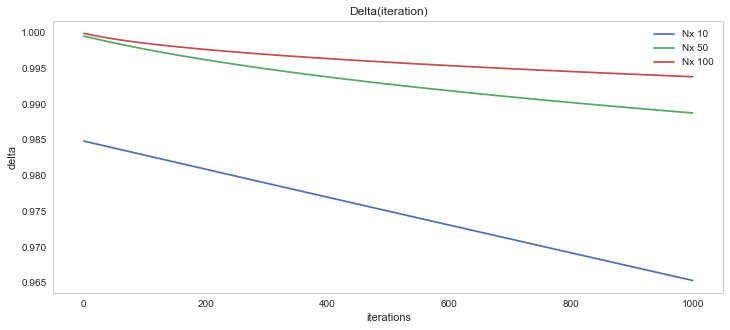

In [24]:
plt.title('Delta(iteration)')

for Nx, delta_NX in delta_Nx.items():
    plt.plot(range(len(delta_NX)), delta_NX, label="Nx "+str(Nx))

plt.xlabel('iterations')
plt.ylabel('delta')
plt.legend()
plt.grid()
plt.figure(figsize=(10, 10))
plt.show()